# Heat equation - Retrieving operator through ODE solving

In [270]:
using LinearAlgebra
using Flux
using DiffEqFlux
using OrdinaryDiffEq
using GalacticOptim
using Plots

include("src/equations/initial_functions.jl")
include("src/equations/equations.jl")
include("src/utils/graphic_tools.jl")
include("src/utils/generators.jl")
include("src/utils/processing_tools.jl")
include("src/neural_ode/objectives.jl")
include("src/neural_ode/models.jl")

Main.Models

## Analytical solution

Compute the analytical solution u(t, x) and the analytical derivative by time of the solution u(t,x)

### Different methods

We make usage of different method to evaluate a solution to the heat equation. Starting from the well-known analytical solution to the equation $u(x,t) = \sum^{\inf}_{n=1} c_n e^{-\pi^2 n^2 t} sin(n \pi x)$,
we implemented as well different methods to study their efficiency with regards to the stability of the equation (explicit, implicit finite-difference, finite-element, pseudo-spectral)

While for testing the quality of our implementation we started with the analytical solution, in the case of heat equation it is interesting to continue with a pseudo-spectral form using FFRT, a numerically stable solution for a large range of parameters.

In [286]:
t_max = 1.;
t_min = 0.;
x_max = 1.;
x_min = 0.;
t_n = 64;
x_n = 64;

typ = 3;
d = 1.;
k = 1.;
kappa = 0.005;
L = x_max - x_min
c = [0.7, 0.3, 0.4];
n = [3, 7, 10];

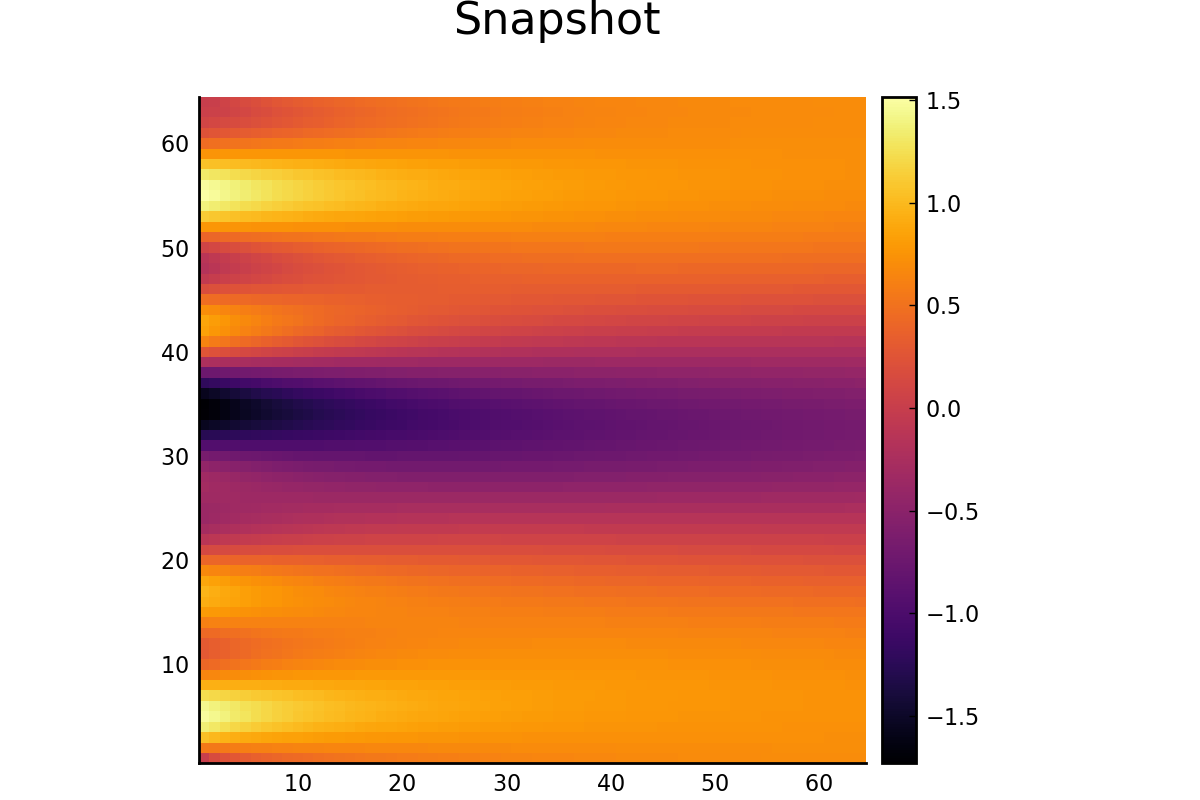

In [244]:
dt = round((t_max - t_min) / (t_n - 1), digits=8);
dx = round((x_max - x_min) / (x_n - 1), digits=8);

t = LinRange(t_min, t_max, t_n);
x = LinRange(x_min, x_max, x_n);

u0 = InitialFunctions.heat_analytical_init(t, x, n, c, k);
t, u = Equations.get_heat_fft(t, dx, x_n, kappa, u0[1, :]);
GraphicTools.show_state(u, "Snapshot") # need to reverse u, odesolver switch dimensions

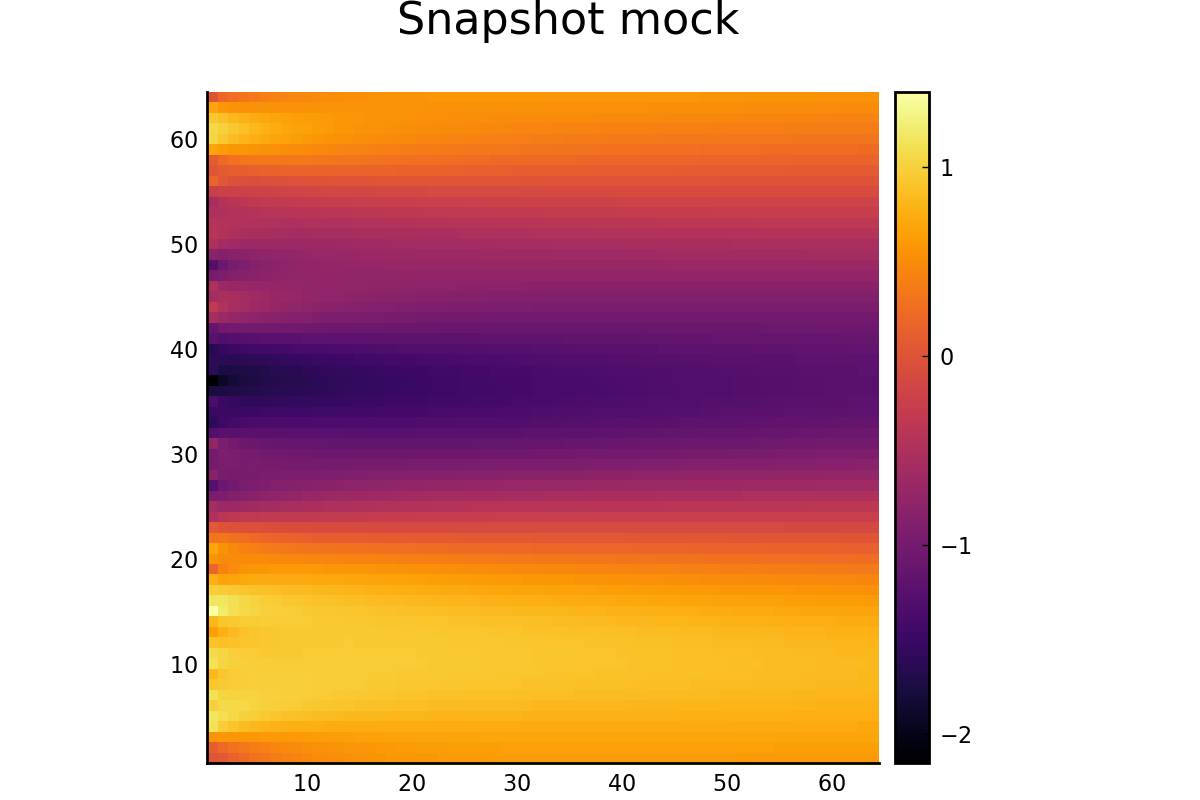

In [245]:
ta, u_a = Generator.heat_snapshot_generator(t_max, t_min, x_max, x_min, t_n, x_n, typ, kappa, k);
GraphicTools.show_state(u_a, "Snapshot mock")

## Generate dataset

In [125]:
function create_solution(c, k, ka)
    X(k, x) = sqrt(2 / L) * sin(pi * k * (x - x_min) / L)
    u(x, t) = sum(c * exp(-ka * (pi * k / L)^2 * t) * X(k, x) for (c, k) in zip(c, k))
    # dudt(x, t) = - sum(c * ka * (pi * k / L)^2 * exp(-d * (pi * k / L)^2 * t) * X(k, x) for(c, k) ∈ zip(c, k))
    u # , dudt
end

create_solution (generic function with 2 methods)

In [287]:
function syver_cond(t_max, t_min, x_max, x_min, t_n, x_n, ka, nsample) 
    tsnap = LinRange(t_min, t_max, t_n)#[2:end]
    K = 50
    k = 1:K
    c = [randn(K) ./ k for _ = 1:nsample]
    u = [create_solution(c, k, ka) for c ∈ c] # solutions =
    init = [u(x, 0.0) for x ∈ x, u ∈ u]
    train = [u(x, t) for x ∈ x, u ∈ u, t ∈ tsnap]
    return tsnap, init, train
end

syver_cond (generic function with 2 methods)

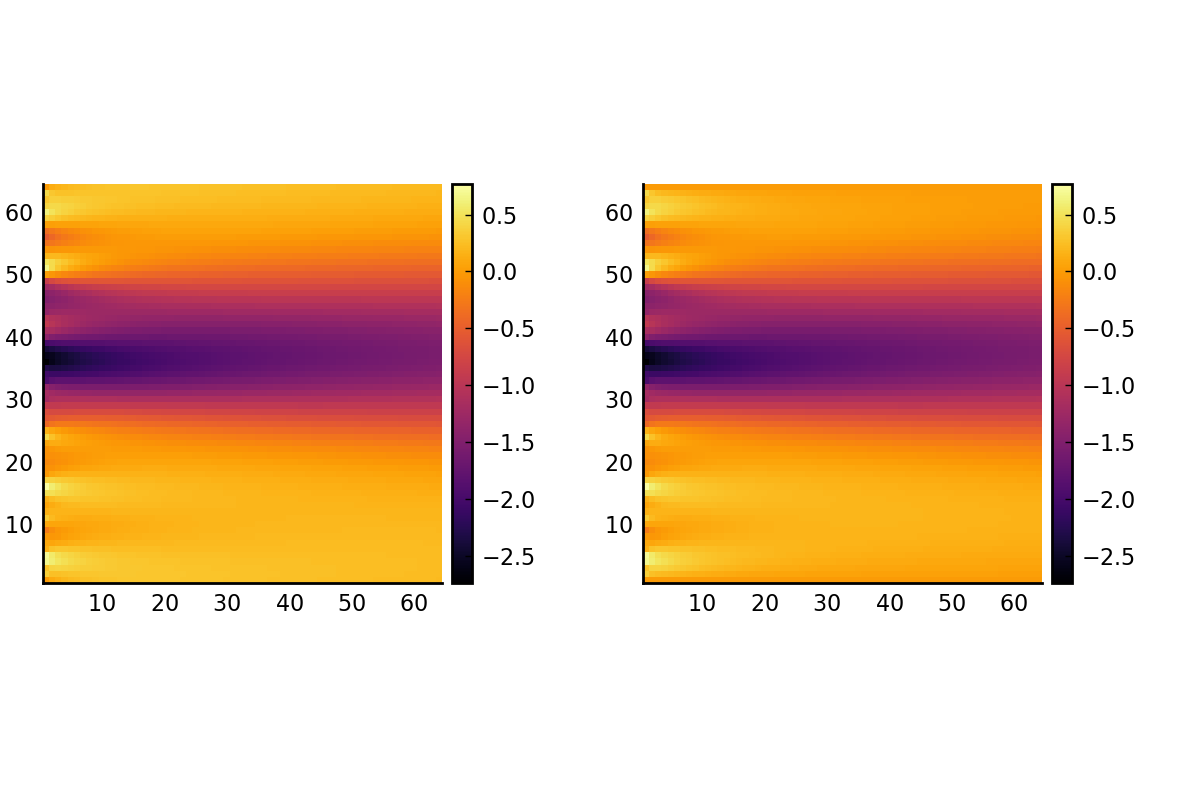

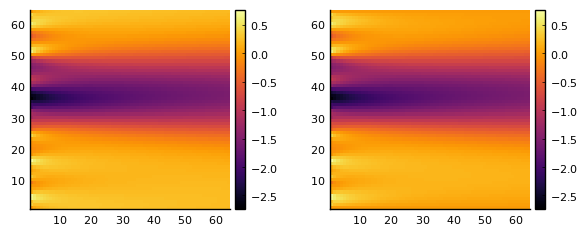

In [300]:
syver_dataset = syver_cond(t_max, t_min, x_max, x_min, t_n, x_n, kappa, 128);
t, init_set, true_set = syver_dataset;
t, u = Equations.get_heat_fft(t, dx, x_n, kappa, init_set[:, 1]);
display(
    plot(
        GraphicTools.show_state(u, ""), # need to reverse u, odesolver switch dimensions
        GraphicTools.show_state(true_set[:, 1, :], "");
    );
);

In [277]:
#dataset = Generator.generate_heat_training_dataset(t_max, t_min, x_max, x_min, t_n, x_n, 32, 2, kappa, k, "./src/dataset/high_dim_training_set.jld2", "training_set");
hand_dataset = Generator.read_dataset("./src/dataset/hand_analytical_heat_training_set.jld2")["training_set"];
analytic_dataset = Generator.read_dataset("./src/dataset/analytical_heat_training_set.jld2")["training_set"];
high_dataset = Generator.read_dataset("./src/dataset/high_dim_training_set.jld2")["training_set"];

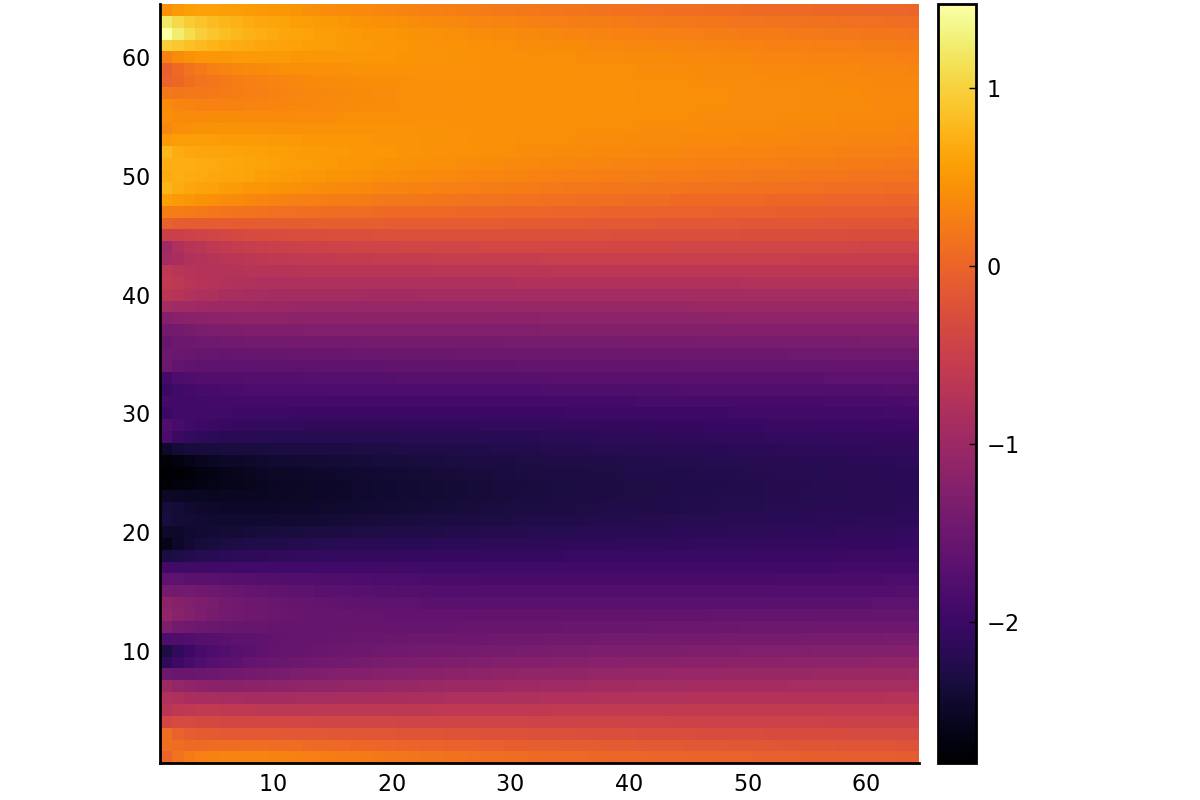

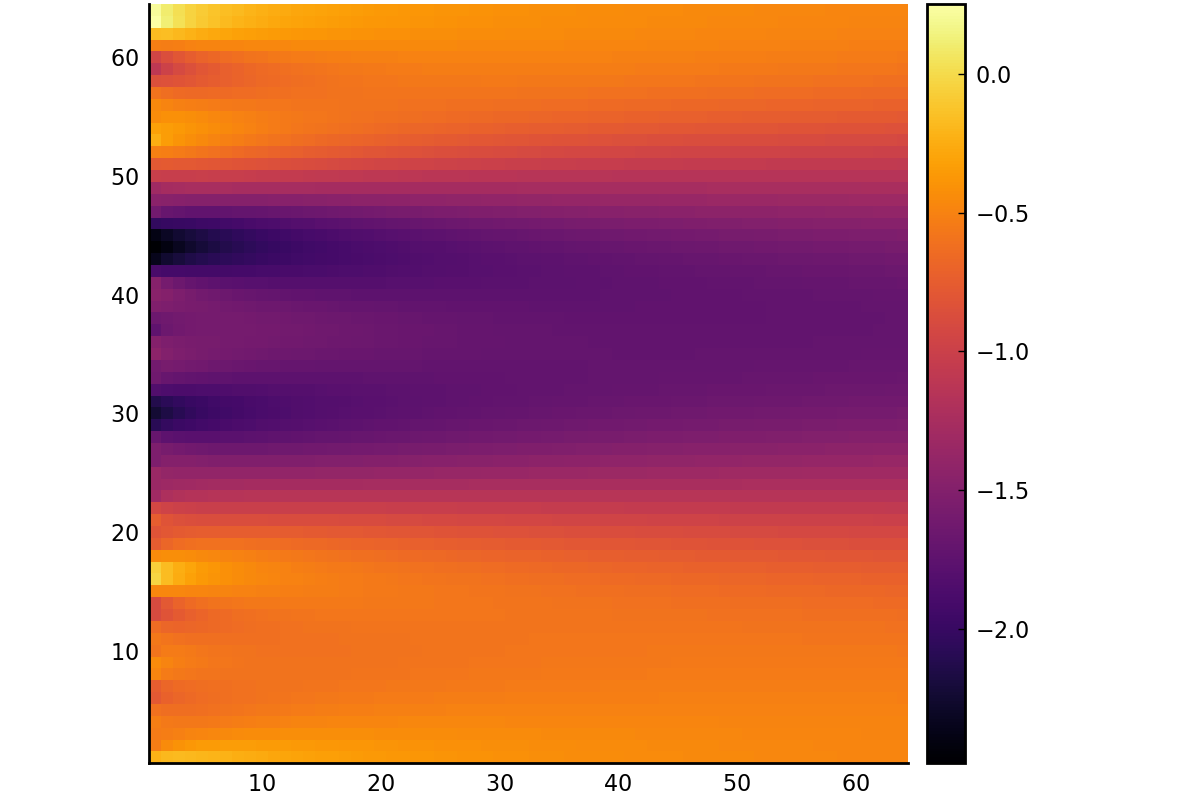

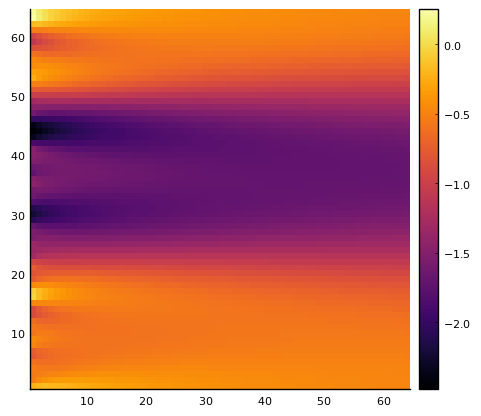

In [348]:
function check_training_dataset(dataset)
    for i in range(1, 2, step=1)
        a, b, c, d = dataset[i];
        display(GraphicTools.show_state(b, ""));
    end
end

check_training_dataset(analytic_dataset)

0.13415777688826241
0.13516229944952354
0.11693250631779212
0.10949401966114643
0.1026123117888989
0.09535371191890304
0.08950135692002203
0.08507044956770385
0.08163743752276624
0.07886673040037817
0.07580779473019751
0.0723480141460326
0.06931093050916196
0.06726967718509261
0.06573792944846012
0.06400463695765117
0.06206926218384038
0.06018872829887856
0.058534650366487584
0.05715802558774423
0.055932515039061256
0.054713648964841516
0.05352095525021401
0.05240291085088948
0.051277479215014465
0.05013482071359947
0.0491179564475437
0.04827893004124911
0.04749430765488509
0.04665871909961576
0.04580313843479396
0.04499053527816841
0.0442599920931509
0.04360012787849486
0.04298025198283974
0.04236917746911738
0.04173490300485683
0.04109966735993836
0.040515217020966304
0.03998488733994403
0.03947942597698495
0.038977518393668184
0.03847360922643286
0.0379750170735736
0.03749487108574874
0.03705196187121484
0.036637681585144494
0.03622143151606565
0.03580071519029256
0.0353927448657019

0.008836711471348848
0.008854168609828648
0.008871086886823294
0.00887433948113355
0.008868826220743661
0.008849709366752358
0.00880949588112594
0.008751266373293102
0.008697387571783285
0.008661580165146076
0.008645284379275787
0.008642737765929819
0.008646319377125095
0.008640978227839649
0.008612917388563441
0.008563896619760415
0.008514027994624404
0.008482195772049585
0.008469974981481707
0.008464307704992308
0.008452287977069144
0.008429495415271219
0.00840040490699424
0.008372857157971834
0.008353047324226828
0.00834177759710622
0.008334535178341474
0.008325229361328047
0.00831051191532159
0.008291571498456626
0.008272122102173327
0.008255538321849684
0.008243100288062834
0.008234636949207227
0.008229958858887776
0.008230296712127782
0.008238985466872127
0.008263124298234507
0.008314606368593888
0.00841423176218127
0.008584034390376114
0.008836745073073426
0.009096739623941984
0.009187179490352835
0.008885663793481591
0.008359129785162699
0.008089362171727647
0.00826386681093624

0.005356513350286321
0.005385355004938635
0.0053593606312382506
0.005319284564976797
0.005334864088402858
0.005350620313369379
0.005330864971225323
0.005317740883182841
0.005316815291218333
0.0053035935110661465
0.005286179848505108
0.0052768167589314335
0.005270371245706865
0.0052636823444590095
0.0052584578967058565
0.005254817069595576
0.005252220890833038
0.005248313695807964
0.005243132690579154
0.005239580634222103
0.005238187178681125
0.0052381100350931
0.0052405736062790574
0.0052463328723940505
0.005256093837838265
0.005271516389864103
0.005292490930567452
0.005319044990507909
0.005351904161228541
0.005386828249203526
0.0054135591341369785
0.005422036419105711
0.005401539412504823
0.005345231978491994
0.005264128543268872
0.005190214648937708
0.005152402276181007
0.005156676409016946
0.00518569158931327
0.005209099897604822
0.005202303180286076
0.005167144973186152
0.0051309598438705264
0.005118206951874888
0.005127874577830294
0.005140031598470386
0.00513707967541884
0.005118

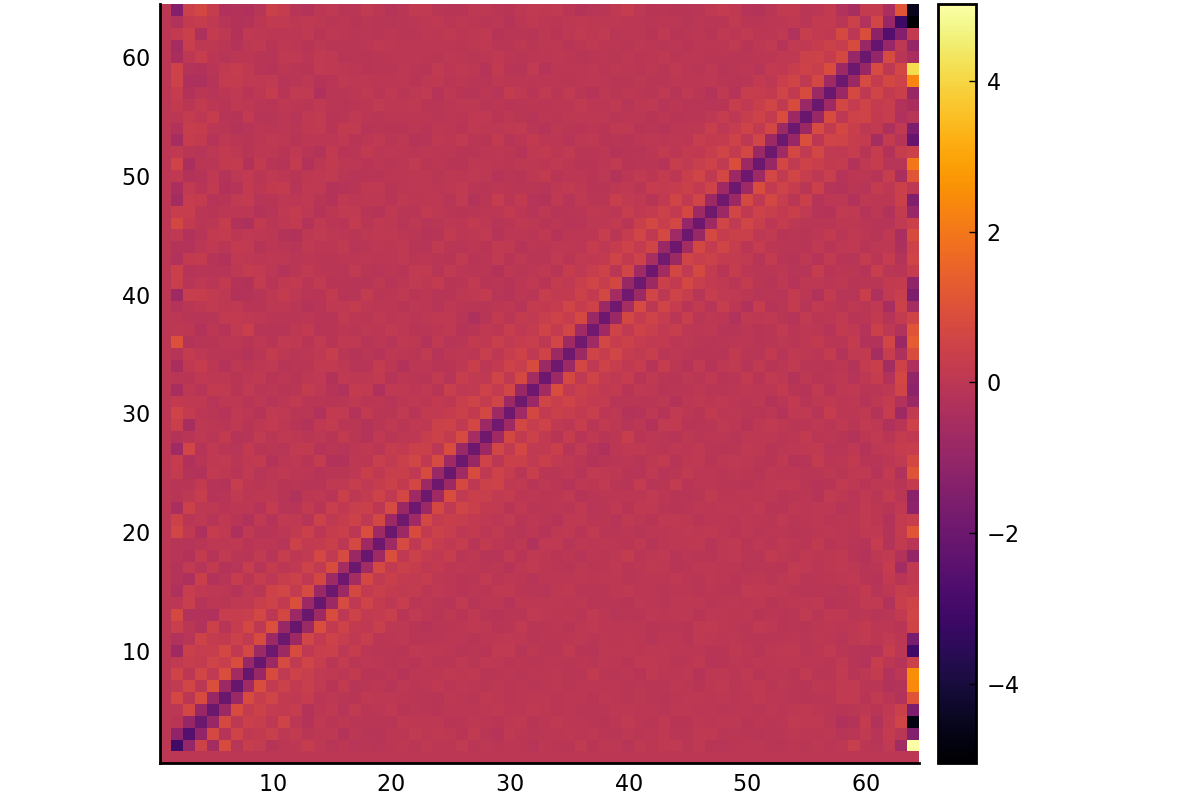

In [387]:
syver_dataset = syver_cond(t_max, t_min, x_max, x_min, t_n, x_n, kappa, 128);
t, init_set, true_set = syver_dataset;
loss(A, u₀, uₜ, t) = sum(abs2, S(A, u₀, t) - uₜ) / prod(size(uₜ));
loss(A) = loss(A, init_set, true_set, t);
A = zeros(x_n, x_n);
callback(A, loss) = (println(loss);flush(stdout);false);
result = DiffEqFlux.sciml_train(loss, A, ADAM(0.01); cb = callback, maxiters = 1000);
K = result.u;
GraphicTools.show_state(K, "")

## Training with NeuralODE object

In [388]:
callback(theta, loss, u) = (IJulia.clear_output(true); display(loss); false)

callback (generic function with 2 methods)

In [378]:
function heat_training(net, epochs, u0, u_true, t)
  optimizer = DiffEqFlux.ADAM(0.01, (0.9, 0.999), 1.0e-8)
  
  tspan = (t[1], t[end])
  neural_ode = NeuralODE(net, tspan, Tsit5(), saveat=t)

  function predict_neural_ode(theta)
    return Array(neural_ode(u0, theta))
  end

  function loss(theta)
    u_pred = predict_neural_ode(theta)
    noise = 1e-8 .* randn(size(u_pred))
    l = Objectives.mseloss(u_pred + noise, u_true)
    return l, u_pred
  end
    
  lossL2(K) = loss(K) + 1e-2 * sum(abs2, K) / prod(size(K))

  result = DiffEqFlux.sciml_train(lossL2, neural_ode.p, optimizer; cb = callback, maxiters = epochs);
  return result
end

heat_training (generic function with 1 method)

In [379]:
t, init_set, true_set = syver_dataset;
#t, init_set, true_set = ProcessingTools.process_dataset(analytic_dataset);
net = Models.HeatModel(x_n);
result = heat_training(net, 100, init_set, true_set, t);

LoadError: MethodError: no method matching +(::Tuple{Float64, Array{Float64, 3}}, ::Float64)
[0mClosest candidates are:
[0m  +(::Any, ::Any, [91m::Any[39m, [91m::Any...[39m) at operators.jl:560
[0m  +([91m::Union{InitialValues.NonspecificInitialValue, InitialValues.SpecificInitialValue{typeof(+)}}[39m, ::Any) at /Users/vdesgrange/.julia/packages/InitialValues/OWP8V/src/InitialValues.jl:154
[0m  +([91m::Union{VectorizationBase.AbstractMask{W, U} where U<:Union{UInt128, UInt16, UInt32, UInt64, UInt8}, VectorizationBase.VecUnroll{var"#s3", W, SIMDTypes.Bit, var"#s2"} where {var"#s3", var"#s2"<:(VectorizationBase.AbstractMask{W, U} where U<:Union{UInt128, UInt16, UInt32, UInt64, UInt8})}} where W[39m, ::Union{Bool, Float16, Float32, Float64, Int16, Int32, Int64, Int8, UInt16, UInt32, UInt64, UInt8, SIMDTypes.Bit}) at /Users/vdesgrange/.julia/packages/VectorizationBase/T91Fn/src/base_defs.jl:348
[0m  ...

### Operator reconstructed

Visualize reconstructed operator and check efficiency to determine solution from unknown sample

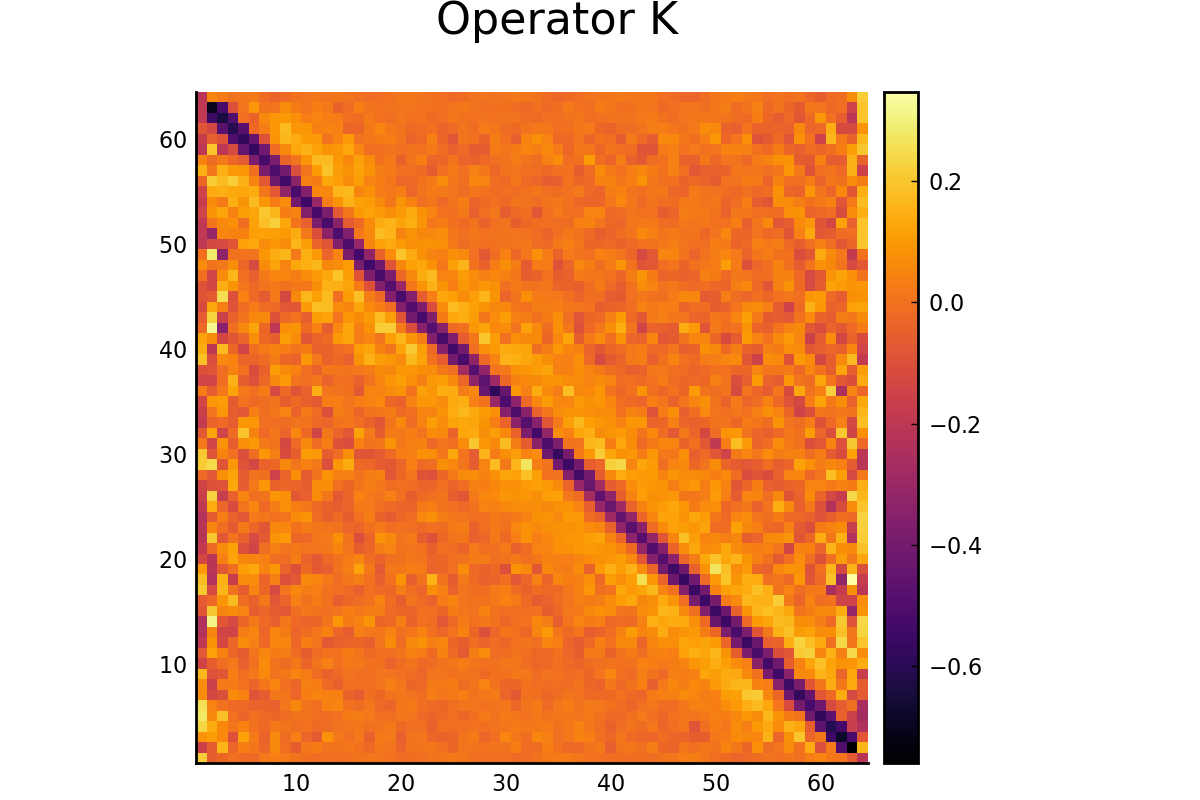

In [360]:
K = reshape(result, (x_n, x_n))
GraphicTools.show_state(reverse(K; dims = 1), "Operator K")

In [352]:
a, b, c = syver_dataset
print(size(c))

(64, 128, 64)

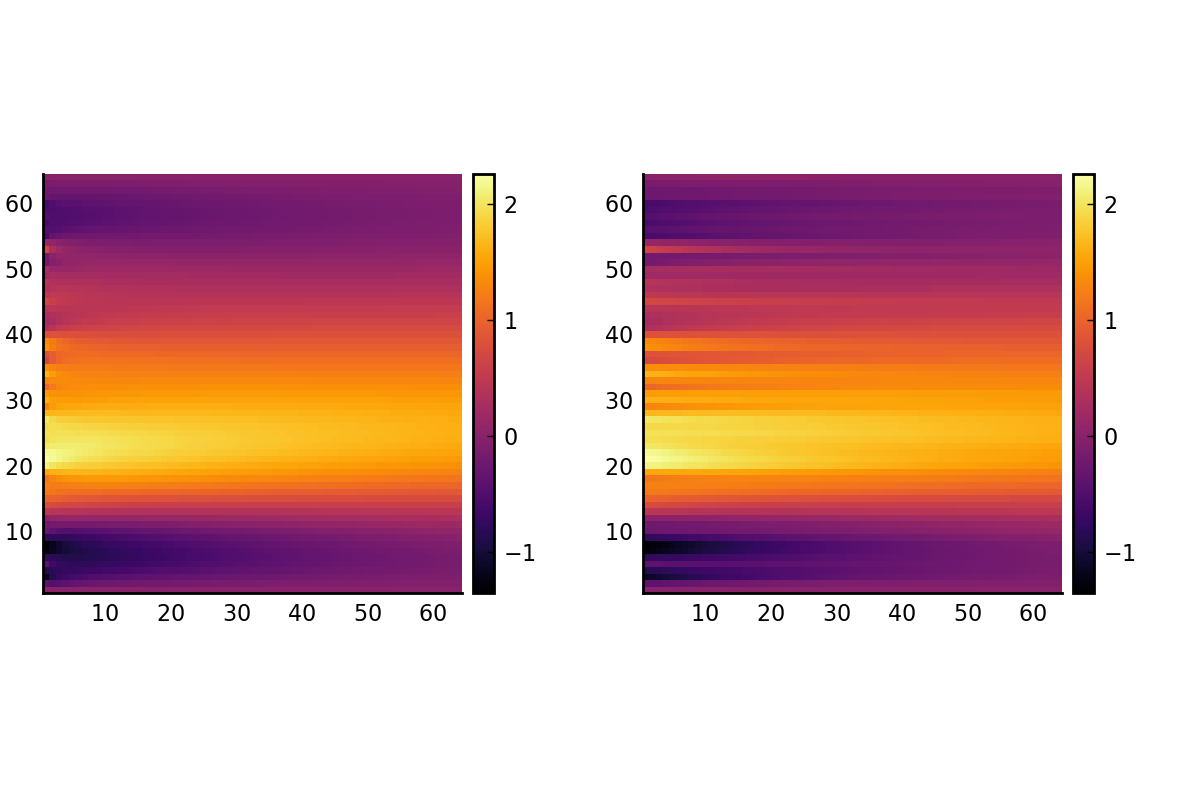

In [392]:
# t, init, train = syver_dataset;
u0 = init_set[:, 50];
u = true_set[:, 50, :];
#t, u0, u = Generator.get_heat_batch(t_max, t_min, x_max, x_min, t_n, x_n, 1, kappa, k);


u_pred = Array(S(K, u0, t));

plot(
    GraphicTools.show_state(u, ""),
    GraphicTools.show_state(u_pred, "");
    layout = (1, 2),
)

## Training with solver

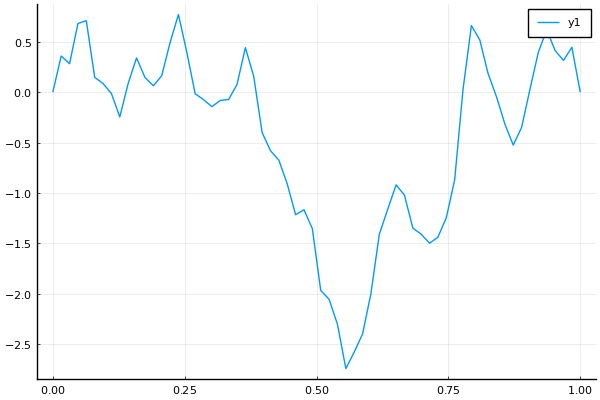

In [311]:
plot(x, init_set[:, 1];)

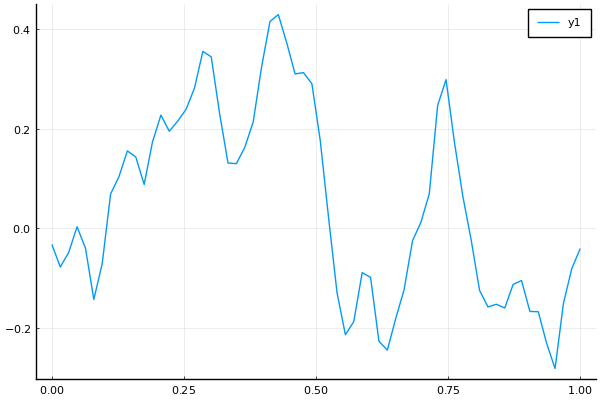

In [314]:
t, u0, u_true = ProcessingTools.process_dataset(hand_dataset)
plot(x, u0[:, 1];)

In [315]:
function f(u, K, t)
  return K * u
end

f (generic function with 1 method)

In [316]:
function S(net, u0, t)
  tspan = (t[1], t[end])
  prob = ODEProblem(ODEFunction(f), copy(u0), tspan, net)
  sol = solve(prob, Tsit5(), saveat=t, reltol=1e-8, abstol=1e-8)
end

S (generic function with 1 method)

In [317]:
callback(A, loss) = (println(loss); flush(stdout); false)

function heat_training_2(A, epochs, u0, u_true, tsnap)
  
  function loss(A)
    u_pred = Array(S(A, u0, tsnap))
    l = Objectives.mseloss(u_pred, u_true)
    return l
  end

  result = DiffEqFlux.sciml_train(loss, A, ADAM(0.01); cb = callback, maxiters = epochs);
  return result
end

heat_training_2 (generic function with 1 method)

In [334]:
net = zeros(x_n, x_n);

In [335]:
t, u0, u_true = ProcessingTools.process_dataset(analytic_dataset);
result_2 = heat_training_2(copy(net), 100, u0, u_true, t);

2.3187772753936855
2.0446151282568206
1.8848316130139091
1.778505539798641
1.7023275209343374
1.644900481409198
1.5999166969310448
1.5636045768430742
1.5335623700563172
1.5081687127305283
1.486282285408659
1.4670845945438726
1.4499900329790527
1.4345837394984144
1.420572253128158
1.4077443174453617
1.3959416916031337
1.385039169268834
1.3749323218981555
1.3655311138705843
1.3567573968118163
1.3485443686612872
1.3408364101918835
1.333588346498462
1.326764004003493
1.3203345416608867
1.3142769443017714
1.3085722372642898
1.3032023759679991
1.2981458999365314
1.2933751412558987
1.2888583949105439
1.2845659477224187
1.280474318305542
1.2765663864846037
1.2728311102077416
1.2692637550267754
1.265862080807957
1.26261924312933
1.2595213120644841
1.2565512907020826
1.2536931373746174
1.2509331083651145
1.2482612995335984
1.245672648450844
1.2431642948149095
1.2407318581071856
1.2383687736275757
1.2360666810316396
1.2338151816020237
1.2316046711817785
1.2294309343812535
1.227294993915387
1.2251

In [336]:
t2, init, train = syver_dataset;
result_3 = heat_training_2(copy(net), 100, init, train, t2);

0.13198111936721396
0.14979828888952124
0.11818317242557738
0.1143801402488574
0.11294045994007881
0.10167174088651576
0.09238437080607953
0.08993850797104498
0.08932234162082245
0.08626210043825135
0.0811850588126333
0.07658688848216229
0.07382588407492366
0.07237357359210903
0.07107241516698187
0.06911504272713366
0.06663726261850711
0.0643426904441147
0.06253328387969073
0.061046187129187385
0.05978082908485391
0.058625641327414345
0.05739835471536983
0.05600697515241422
0.05458258085161079
0.05331317328003477
0.05229592200747778
0.051507428042547945
0.05071956817229817
0.04976069772109662
0.048728433702473845
0.04780107093609978
0.047053012777638945
0.04637306079869977
0.04566130404642242
0.04496142945625655
0.04429649663220074
0.0436528727612402
0.043020732251992
0.042399976729354645
0.04181994309659259
0.04129029598120127
0.040796857995405084
0.040300917711723276
0.03978559326773548
0.03927303939530296
0.0387911269777467
0.03835507164098595
0.037943136824150694
0.03752664193379
0

In [340]:
t3, u03, u_true3 = ProcessingTools.process_dataset(high_dataset);
result_4 = heat_training_2(copy(net), 100, u03, u_true3, t3);

1.236406039875372
1.128196624196026
1.0492219642640028
0.9884717921657091
0.9396442016390432
0.8990527040406766
0.8644711708724024
0.8344713577270892
0.8080690724637509
0.784538738268136
0.7633299395423572
0.7440321156550953
0.7263492877686698
0.7100714032896837
0.6950462800319674
0.6811573703702845
0.6683075823266034
0.6564083979391964
0.645375028923268
0.6351272958839574
0.6255934442789672
0.6167131225405995
0.6084368766484715
0.6007222512641484
0.5935291971031867
0.5868176428676293
0.5805478754646647
0.5746818944560788
0.5691833319942172
0.5640160240374024
0.5591443642307428
0.5545373075003872
0.5501723209076292
0.5460337024148977
0.5421064063568954
0.5383727164294524
0.5348150789801295
0.5314194736384082
0.5281740872284787
0.5250672404046383
0.522088930102631
0.5192317246407715
0.5164883633252815
0.5138515380999619
0.5113162099423832
0.5088776816510003
0.5065283357543984
0.5042612432985096
0.5020739782864078
0.49996384187340803
0.49792458746635826
0.49595133897934096
0.494041525821

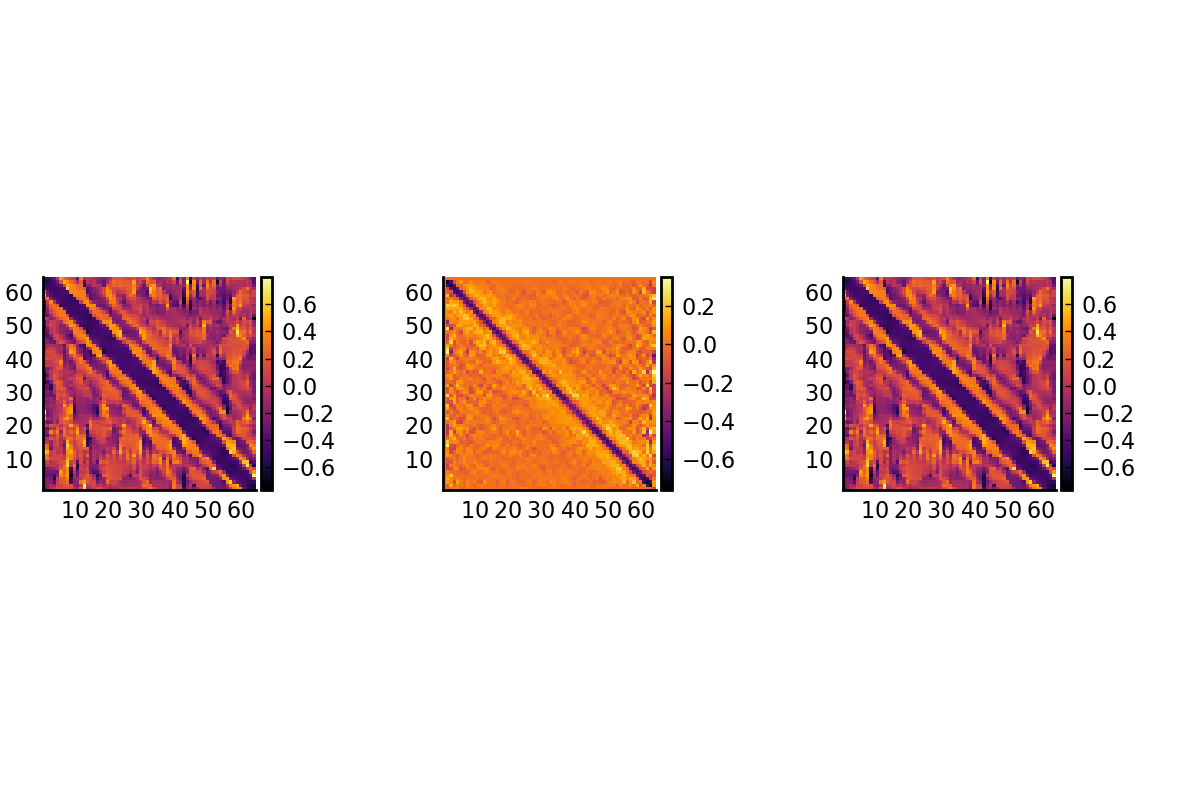

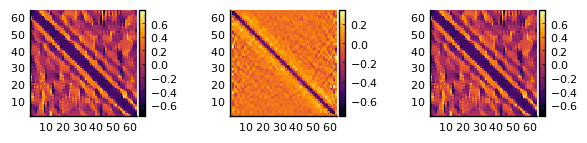

In [346]:
K2 = result_2.u
K3 = result_3.u;
K4 = result_4.u;

display(
    plot(
        GraphicTools.show_state(reverse(K2; dims = 1), ""),
        GraphicTools.show_state(reverse(K3; dims = 1), ""),
        GraphicTools.show_state(reverse(K4; dims = 1), "");
        layout = (1, 3),
    ),
);  

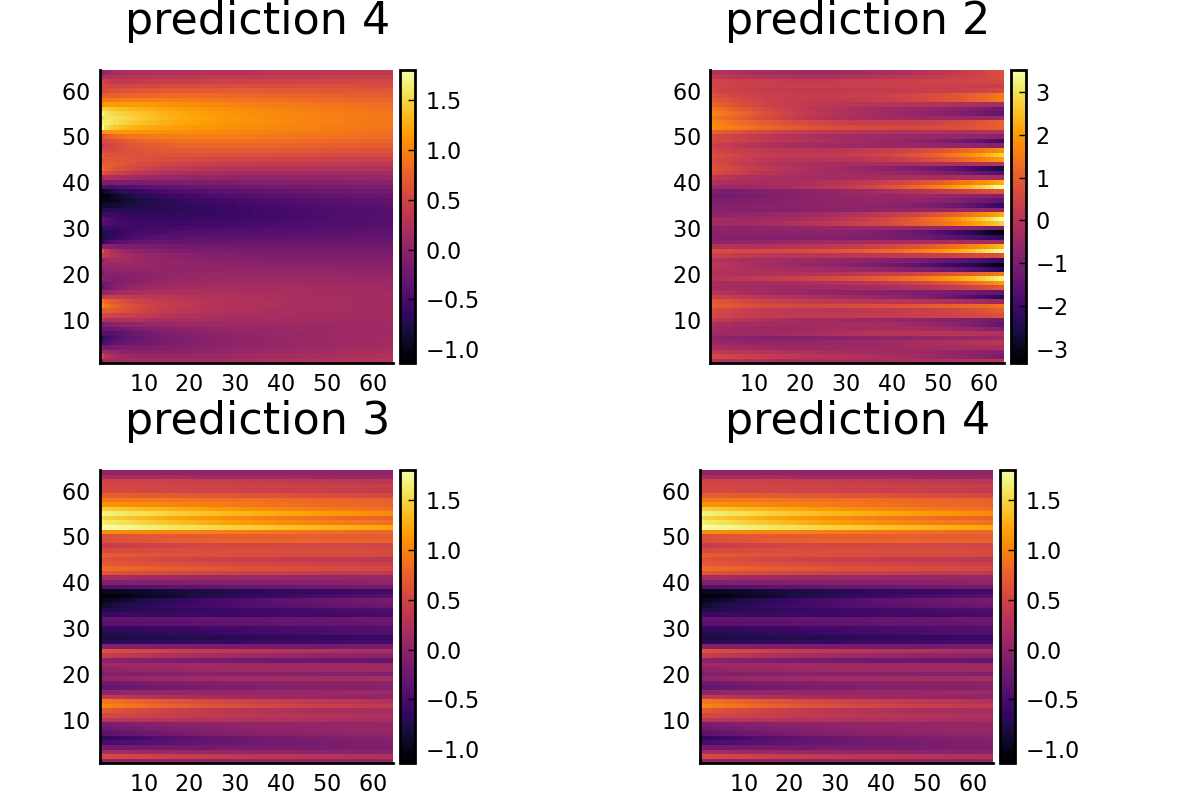

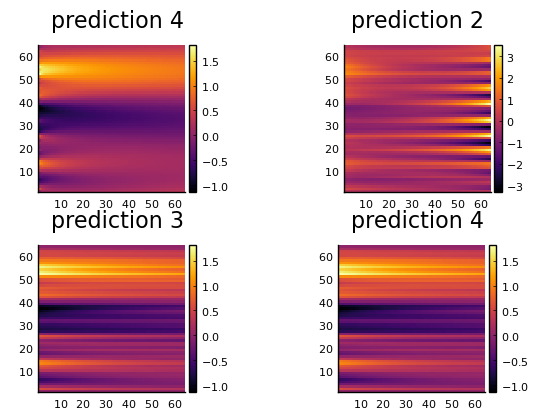

In [347]:
# t, u0, u_true = ProcessingTools.process_dataset(dataset);

t, u0, u = Generator.get_heat_batch(t_max, t_min, x_max, x_min, t_n, x_n, 3, kappa, k);
# u_pred = Array(S(Afit, u0[, t));
u_pred_2 = Array(S(K2, u0, t));
u_pred_3 = Array(S(K3, u0, t));
u_pred_4 = Array(S(K4, u0, t));
# neural_ode = NeuralODE(net, (t[1], t[end]), Tsit5(), saveat=t)
# u_pred = Array(neural_ode(u0, result))

display(
    plot(
        GraphicTools.show_state(u, "data"),
        #GraphicTools.show_state(u_pred, "prediction 1"),
        GraphicTools.show_state(u_pred_2, "prediction 2"),
        GraphicTools.show_state(u_pred_3, "prediction 3"),
        GraphicTools.show_state(u_pred_3, "prediction 4");
        layout = (2, 2),
    ),
);